In [1]:
 pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload() #upload kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mirtavucinic","key":"c4136663ac663d4e32c581d094f31cb7"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00


In [8]:
! pip install pydub

In [39]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    LSTM,
    Dropout,
    Dense,
    MaxPooling2D,
    Flatten,
)
import time
import librosa.display
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
import random
import os
from pydub import AudioSegment
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import cross_val_score, cross_val_predict
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, roc_curve, classification_report
from PIL import Image

In [10]:
! kaggle datasets download birdy654/deep-voice-deepfake-voice-recognition

Dataset URL: https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition
License(s): other
100% 3.67G/3.69G [00:51<00:00, 183MB/s]
100% 3.69G/3.69G [00:51<00:00, 76.1MB/s]


In [11]:
!unzip deep-voice-deepfake-voice-recognition.zip -d /content/dataset

Archive:  deep-voice-deepfake-voice-recognition.zip
  inflating: /content/dataset/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3  
  inflating: /content/dataset/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/Obama-to-Trump.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-Obama.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-Trump.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-linus.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-margot.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-musk.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-ryan.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-taylor.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/linus-to-biden.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/linus-to-margot.wav  
  inflating: /content

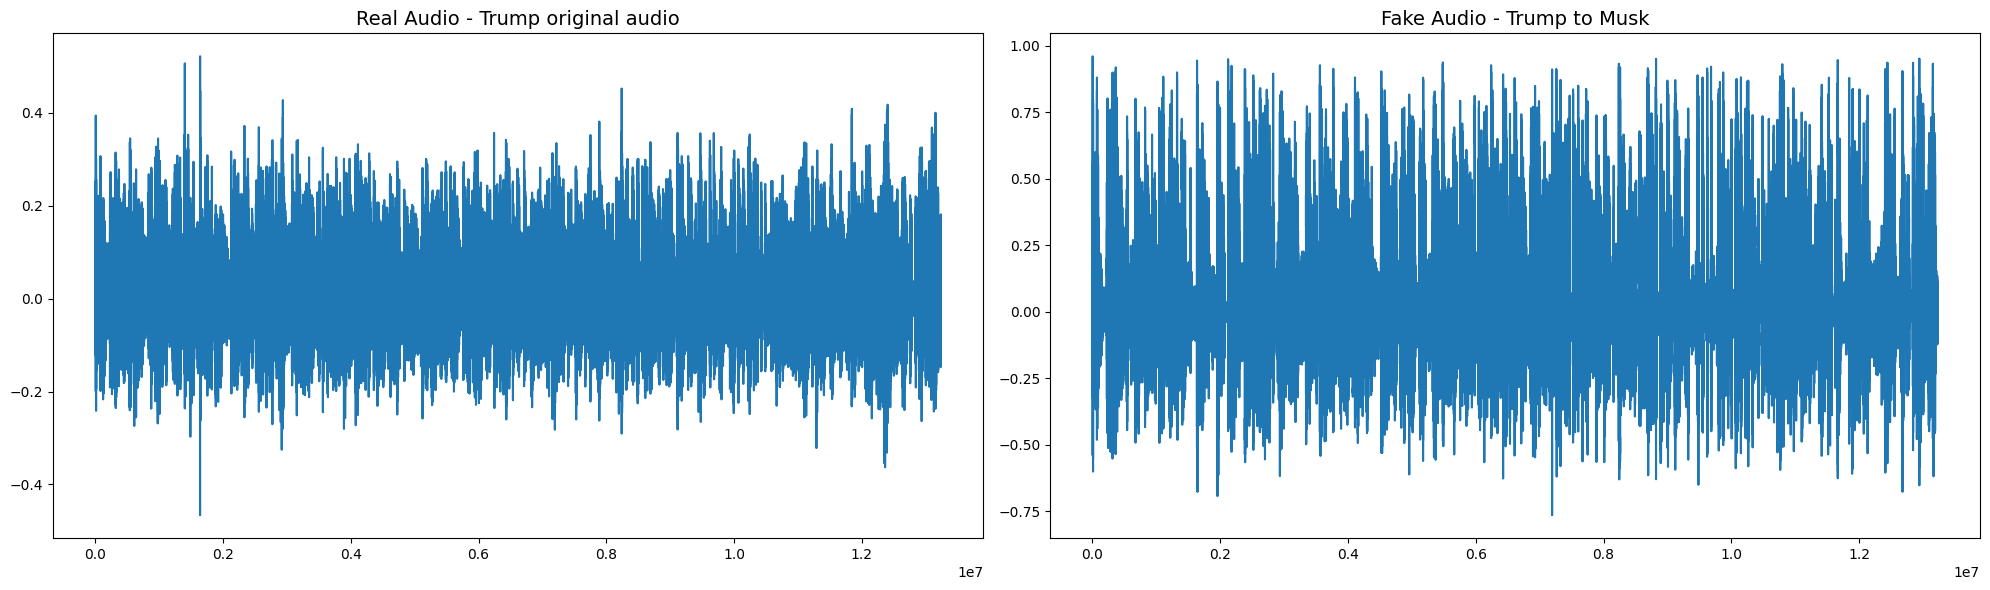

In [12]:
real_audio = "/content/dataset/KAGGLE/AUDIO/REAL/trump-original.wav"
fake_audio = "/content/dataset/KAGGLE/AUDIO/FAKE/trump-to-musk.wav"

real_ad, real_sr = librosa.load(real_audio)
fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(real_ad)
plt.title('Real Audio - Trump original audio', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(fake_ad)
plt.title('Fake Audio - Trump to Musk', fontsize=14)


plt.tight_layout()
plt.show()


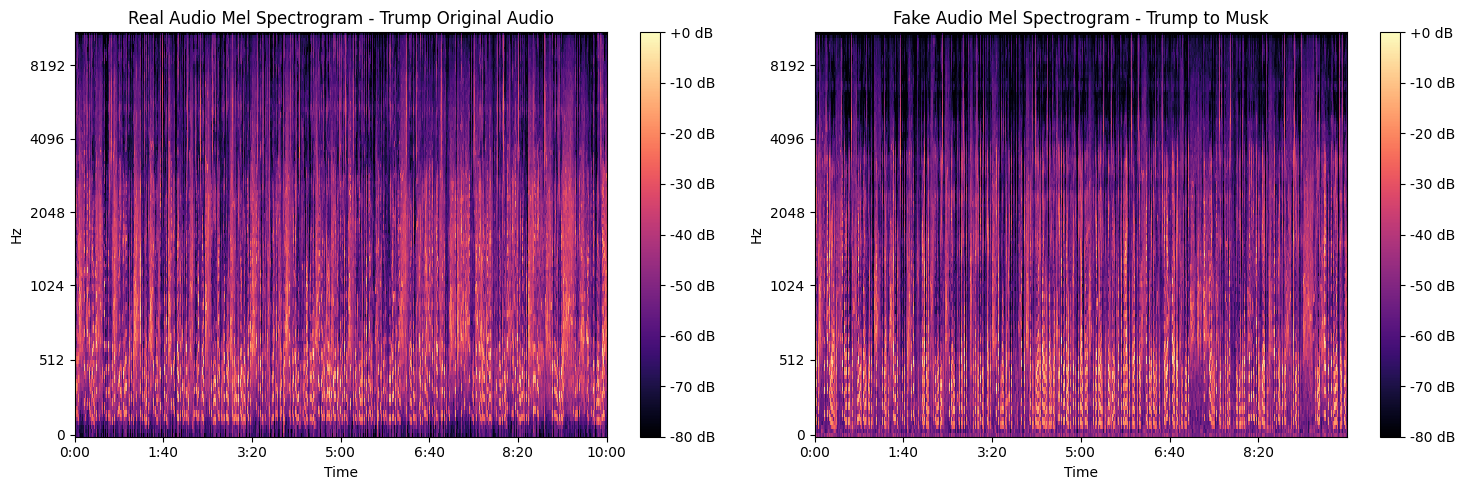

In [13]:
real_mel_spect = librosa.feature.melspectrogram(y = real_ad, sr = real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref = np.max)

fake_mel_spect = librosa.feature.melspectrogram(y = fake_ad, sr = fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref = np.max)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

librosa.display.specshow(real_mel_spect, y_axis='mel', x_axis='time', ax=ax[0])
ax[0].set_title('Real Audio Mel Spectrogram - Trump Original Audio')
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Frequency")
fig.colorbar(librosa.display.specshow(real_mel_spect, y_axis='mel', x_axis='time', ax=ax[0]), ax=ax[0], format='%+2.0f dB')

librosa.display.specshow(fake_mel_spect, y_axis='mel', x_axis='time', ax=ax[1])
ax[1].set_title('Fake Audio Mel Spectrogram - Trump to Musk')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Frequency")
fig.colorbar(librosa.display.specshow(fake_mel_spect, y_axis='mel', x_axis='time', ax=ax[1]), ax=ax[1], format='%+2.0f dB')

plt.tight_layout()
plt.show()

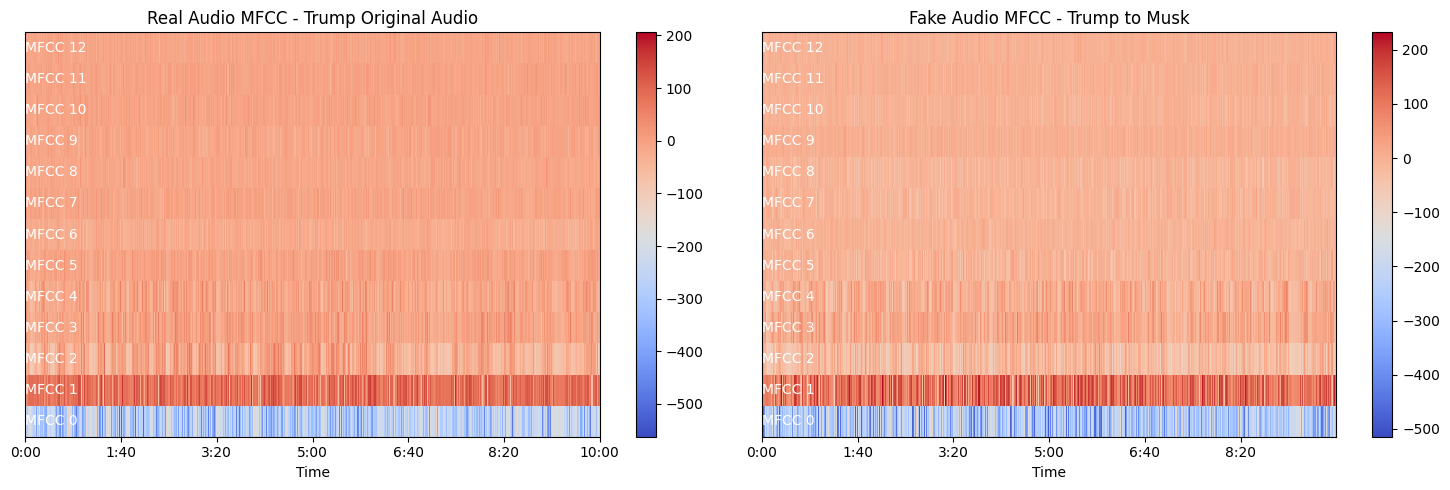

In [15]:
real_mfcc = librosa.feature.mfcc(y = real_ad, sr = real_sr, n_mfcc = 13)
fake_mfcc = librosa.feature.mfcc(y = fake_ad, sr = fake_sr, n_mfcc = 13)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

librosa.display.specshow(real_mfcc, sr=real_sr, x_axis='time', ax=ax[0])
ax[0].set_title('Real Audio MFCC - Trump Original Audio')
ax[0].set_ylabel('MFCC Coefficients')
fig.colorbar(librosa.display.specshow(real_mfcc, sr=real_sr, x_axis='time', ax=ax[0]), ax=ax[0])
for i in range(13):
    ax[0].text(0, i, f'MFCC {i}', color='white', fontsize=10, verticalalignment='center')

librosa.display.specshow(fake_mfcc, sr=fake_sr, x_axis='time', ax=ax[1])
ax[1].set_title('Fake Audio MFCC - Trump to Musk')
ax[1].set_ylabel('MFCC Coefficients')
fig.colorbar(librosa.display.specshow(fake_mfcc, sr=fake_sr, x_axis='time', ax=ax[1]), ax=ax[1])
for i in range(13):
    ax[1].text(0, i, f'MFCC {i}', color='white', fontsize=10, verticalalignment='center')

plt.tight_layout()
plt.show()

In [16]:

dataset_path = "/content/dataset/KAGGLE/AUDIO"
augmented_dataset_path = "/kaggle/working/SPLITTED"

os.makedirs(augmented_dataset_path, exist_ok=True)
os.makedirs(os.path.join(augmented_dataset_path, "FAKE"), exist_ok=True)
os.makedirs(os.path.join(augmented_dataset_path, "REAL"), exist_ok=True)

def split_audio_file(file_path, output_dir, segment_length=10):
    audio = AudioSegment.from_wav(file_path)
    duration = audio.duration_seconds
    segment_length_ms = segment_length * 1000

    segments = []
    for i in range(0, len(audio), segment_length_ms):
        segment = audio[i:i + segment_length_ms]
        segment_file_name = f"{os.path.splitext(os.path.basename(file_path))[0]}_part{i // segment_length_ms}.wav"
        segment_path = os.path.join(output_dir, segment_file_name)
        segment.export(segment_path, format="wav")
        segments.append(segment_path)
    return segments

real_samples_path = os.path.join(dataset_path, "REAL")
for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    output_dir = os.path.join(augmented_dataset_path, "REAL")
    split_audio_file(file_path, output_dir)

fake_samples_path = os.path.join(dataset_path, "FAKE")
fake_segments = []
for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    output_dir = os.path.join(augmented_dataset_path, "FAKE")
    fake_segments.extend(split_audio_file(file_path, output_dir))

selected_fake_segments = random.sample(fake_segments, len(os.listdir("/kaggle/working/SPLITTED/REAL")))

selected_fake_path = os.path.join(augmented_dataset_path, "SELECTED_FAKE")
os.makedirs(selected_fake_path, exist_ok=True)
for segment in selected_fake_segments:
    segment_file_name = os.path.basename(segment)
    os.rename(segment, os.path.join(selected_fake_path, segment_file_name))

<ipython-input-17-da10bd04fdfc>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=data_pre_augmentation, ax=axes[0], palette=['#1f77b4', '#ff7f0e'])
<ipython-input-17-da10bd04fdfc>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=data_post_augmentation, ax=axes[1], palette=['#1f77b4', '#ff7f0e'])


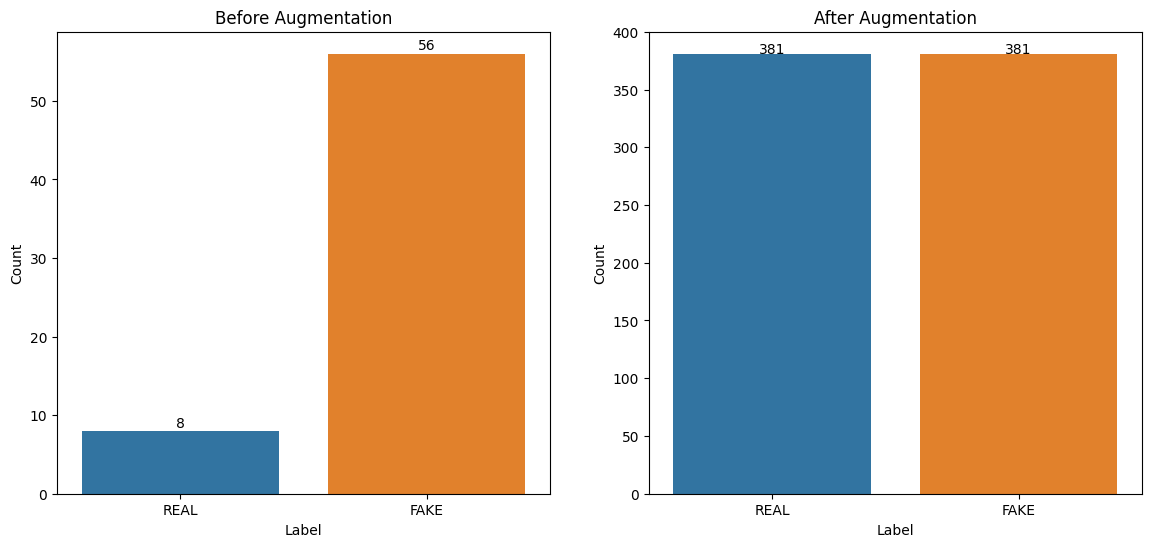

In [17]:

original_real_path = os.path.join(dataset_path, "REAL")
original_fake_path = os.path.join(dataset_path, "FAKE")
augmented_real_path = os.path.join(augmented_dataset_path, "REAL")
augmented_fake_path = os.path.join(augmented_dataset_path, "SELECTED_FAKE")

num_original_real = len(os.listdir(original_real_path))
num_original_fake = len(os.listdir(original_fake_path))


num_augmented_real = len(os.listdir(augmented_real_path))
num_augmented_fake = len(os.listdir(augmented_fake_path))


data_pre_augmentation = {'Label': ['REAL', 'FAKE'], 'Count': [num_original_real, num_original_fake]}
data_post_augmentation = {'Label': ['REAL', 'FAKE'], 'Count': [num_augmented_real, num_augmented_fake]}


fig, axes = plt.subplots(1, 2, figsize=(14, 6))


sns.barplot(x='Label', y='Count', data=data_pre_augmentation, ax=axes[0], palette=['#1f77b4', '#ff7f0e'])
axes[0].set_title('Before Augmentation')
for i, count in enumerate(data_pre_augmentation['Count']):
    axes[0].text(i, count + 0.5, str(count), ha='center')


sns.barplot(x='Label', y='Count', data=data_post_augmentation, ax=axes[1], palette=['#1f77b4', '#ff7f0e'])
axes[1].set_title('After Augmentation')
for i, count in enumerate(data_post_augmentation['Count']):
    axes[1].text(i, count + 0.5, str(count), ha='center')

plt.show()

In [18]:

def extract_features(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

fake_samples_path = "/kaggle/working/SPLITTED/SELECTED_FAKE"
real_samples_path = "/kaggle/working/SPLITTED/REAL"

features = []
labels = []

for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_features(file_path))
        labels.append(0)


for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_features(file_path))
        labels.append(1)

X = np.array(features)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=144
  warnings.warn(


In [19]:
model_accuracy={}

# Naive Bayes

In [92]:
start_train = time.time()
model = GaussianNB()
model.fit(X_train, y_train)
end_train = time.time()

start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()
pred_time = end_pred - start_pred

In [93]:
start_metrics = time.time()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
end_metrics = time.time()
metrics_time = end_metrics - start_metrics

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["Naive Bayes"] = accuracy

Accuracy: 0.8431372549019608
Precision: 0.90625
Recall: 0.7631578947368421
F1-score: 0.8285714285714286


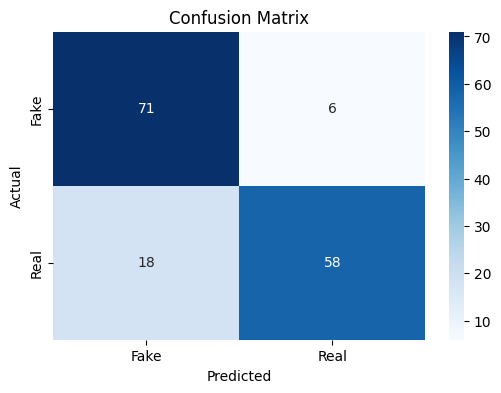

In [94]:
start_cm = time.time()
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
end_cm = time.time()
cm_time = end_cm - start_cm

In [95]:
start_cr = time.time()
print(classification_report(y_test, y_pred))
end_cr = time.time()
cr_time = end_cr - start_cr

              precision    recall  f1-score   support

           0       0.80      0.92      0.86        77
           1       0.91      0.76      0.83        76

    accuracy                           0.84       153
   macro avg       0.85      0.84      0.84       153
weighted avg       0.85      0.84      0.84       153



In [96]:
train_time = end_train - start_train
total_eval_time = pred_time + metrics_time + cm_time + cr_time

print(f"Training time: {train_time:.4f} seconds")
print(f"Evaluation time: {total_eval_time:.4f} seconds")

Training time: 0.0034 seconds
Evaluation time: 0.3017 seconds


In [97]:
y_pred_cv = cross_val_predict(model, X, y, cv=5)
accuracies = cross_val_score(model, X, y, cv=5, scoring='accuracy')
precisions= cross_val_score(model, X, y, cv=5, scoring='precision')
recalls = cross_val_score(model, X, y, cv=5, scoring='recall')
f1_scores = cross_val_score(model, X, y, cv=5, scoring='f1')
print(f"Average Accuracy from Cross-Validation: {np.mean(accuracies):.4f}")
print(f"Average Precision from Cross-Validation: {np.mean(precisions):.4f}")
print(f"Average Recall from Cross-Validation: {np.mean(recalls):.4f}")
print(f"Average F1-Score from Cross-Validation: {np.mean(f1_scores):.4f}")

Average Accuracy from Cross-Validation: 0.8687
Average Precision from Cross-Validation: 0.8960
Average Recall from Cross-Validation: 0.8348
Average F1-Score from Cross-Validation: 0.8636


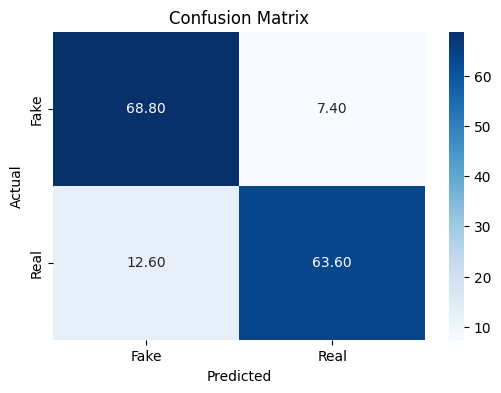

In [98]:
cm = confusion_matrix(y, y_pred_cv)
plt.figure(figsize=(6, 4))
sns.heatmap(cm / 5, fmt=".2f", annot=True, cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# K-Nearest Neighbors (KNN)



In [99]:
start_train = time.time()
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'], refit='accuracy')

grid_search.fit(X_train, y_train)
end_train = time.time()

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

Best parameters: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'uniform', 'selector__k': 13}
Best score: 0.9934426229508198


In [100]:
best_model = grid_search.best_estimator_
start_pred = time.time()
y_pred = best_model.predict(X_test)
end_pred = time.time()
pred_time = end_pred - start_pred

In [101]:
start_metrics = time.time()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
end_metrics = time.time()
metrics_time = end_metrics - start_metrics

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["KNN"] = accuracy

Accuracy: 0.9869281045751634
Precision: 0.9868421052631579
Recall: 0.9868421052631579
F1-score: 0.9868421052631579


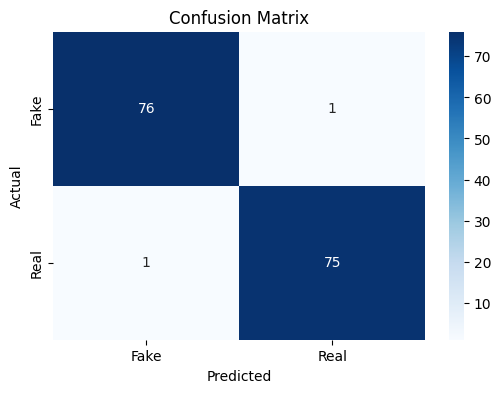

In [102]:
start_cm = time.time()
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
end_cm = time.time()
cm_time = end_cm - start_cm

In [103]:
start_cr = time.time()
print(classification_report(y_test, y_pred))
end_cr = time.time()
cr_time = end_cr - start_cr

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        77
           1       0.99      0.99      0.99        76

    accuracy                           0.99       153
   macro avg       0.99      0.99      0.99       153
weighted avg       0.99      0.99      0.99       153



In [104]:
train_time = end_train - start_train
total_eval_time = pred_time + metrics_time + cm_time + cr_time

print(f"Training time: {train_time:.4f} seconds")
print(f"Evaluation time: {total_eval_time:.4f} seconds")

Training time: 8.9659 seconds
Evaluation time: 0.3236 seconds


In [105]:
y_pred_cv = cross_val_predict(best_model, X, y, cv=5)

accuracies = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
precisions = cross_val_score(best_model, X, y, cv=5, scoring='precision')
recalls = cross_val_score(best_model, X, y, cv=5, scoring='recall')
f1_scores = cross_val_score(best_model, X, y, cv=5, scoring='f1')

print(f"Average Accuracy from Cross-Validation: {np.mean(accuracies):.4f}")
print(f"Average Precision from Cross-Validation: {np.mean(precisions):.4f}")
print(f"Average Recall from Cross-Validation: {np.mean(recalls):.4f}")
print(f"Average F1-Score from Cross-Validation: {np.mean(f1_scores):.4f}")


Average Accuracy from Cross-Validation: 0.9908
Average Precision from Cross-Validation: 0.9895
Average Recall from Cross-Validation: 0.9921
Average F1-Score from Cross-Validation: 0.9908


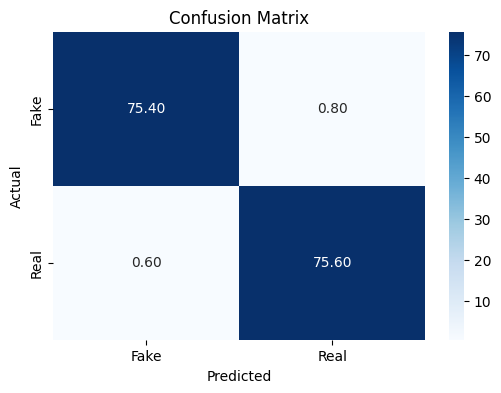

In [106]:
cm = confusion_matrix(y, y_pred_cv)
plt.figure(figsize=(6, 4))
sns.heatmap(cm / 5, fmt=".2f", annot=True, cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Support Vector Machine (SVM)

In [107]:
start_train = time.time()
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('svm', SVC(probability=True))
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['linear', 'rbf']
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)
end_train = time.time()

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

Best parameters: {'selector__k': 11, 'svm__C': 100, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Best score: 0.9934426229508198


In [108]:
best_model = grid_search.best_estimator_
start_pred = time.time()
y_pred = best_model.predict(X_test)
end_pred = time.time()
pred_time = end_pred - start_pred

In [109]:
start_metrics = time.time()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
end_metrics = time.time()
metrics_time = end_metrics - start_metrics

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["SVM"] = accuracy

Accuracy: 0.9738562091503268
Precision: 0.9736842105263158
Recall: 0.9736842105263158
F1-score: 0.9736842105263158


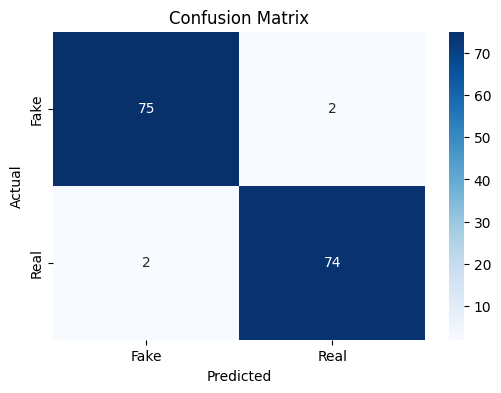

In [110]:
start_cm = time.time()
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
end_cm = time.time()
cm_time = end_cm - start_cm

In [111]:
start_cr = time.time()
print(classification_report(y_test, y_pred))
end_cr = time.time()
cr_time = end_cr - start_cr

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        77
           1       0.97      0.97      0.97        76

    accuracy                           0.97       153
   macro avg       0.97      0.97      0.97       153
weighted avg       0.97      0.97      0.97       153



In [112]:
train_time = end_train - start_train
total_eval_time = pred_time + metrics_time + cm_time + cr_time

print(f"Training time: {train_time:.4f} seconds")
print(f"Evaluation time: {total_eval_time:.4f} seconds")

Training time: 63.5524 seconds
Evaluation time: 0.2169 seconds


In [113]:
y_pred_cv = cross_val_predict(best_model, X, y, cv=5)

accuracies = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
precisions = cross_val_score(best_model, X, y, cv=5, scoring='precision')
recalls = cross_val_score(best_model, X, y, cv=5, scoring='recall')
f1_scores = cross_val_score(best_model, X, y, cv=5, scoring='f1')

print(f"Average Accuracy from Cross-Validation: {np.mean(accuracies):.4f}")
print(f"Average Precision from Cross-Validation: {np.mean(precisions):.4f}")
print(f"Average Recall from Cross-Validation: {np.mean(recalls):.4f}")
print(f"Average F1-Score from Cross-Validation: {np.mean(f1_scores):.4f}")

Average Accuracy from Cross-Validation: 0.9882
Average Precision from Cross-Validation: 0.9895
Average Recall from Cross-Validation: 0.9869
Average F1-Score from Cross-Validation: 0.9881


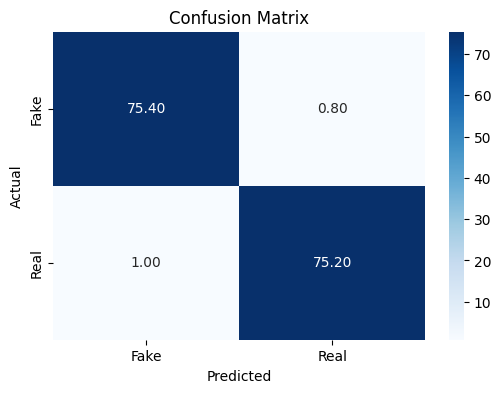

In [114]:
cm = confusion_matrix(y, y_pred_cv)
plt.figure(figsize=(6, 4))
sns.heatmap(cm / 5, fmt=".2f", annot=True, cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Logistic Regression

In [115]:
start_train = time.time()
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear', 'saga']
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)
end_train = time.time()
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

best_model = grid_search.best_estimator_
start_pred = time.time()
y_pred = best_model.predict(X_test)
end_pred = time.time()
pred_time = end_pred - start_pred

Best parameters: {'lr__C': 0.1, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'selector__k': 13}
Best score: 0.8587725240482321


In [116]:
start_metrics = time.time()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
end_metrics = time.time()
metrics_time = end_metrics - start_metrics

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["Logistic Regression"] = accuracy

Accuracy: 0.8104575163398693
Precision: 0.8507462686567164
Recall: 0.75
F1-score: 0.7972027972027972


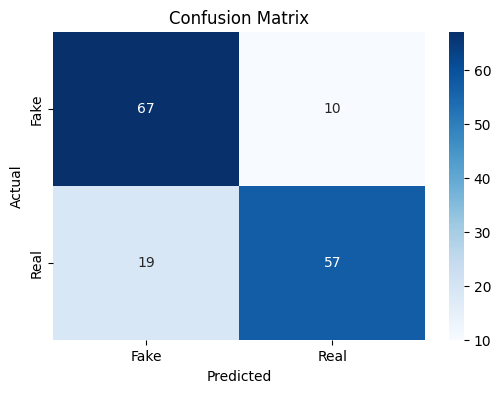

In [117]:
start_cm = time.time()
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
end_cm = time.time()
cm_time = end_cm - start_cm

In [118]:
start_cr = time.time()
print(classification_report(y_test, y_pred))
end_cr = time.time()
cr_time = end_cr - start_cr

              precision    recall  f1-score   support

           0       0.78      0.87      0.82        77
           1       0.85      0.75      0.80        76

    accuracy                           0.81       153
   macro avg       0.81      0.81      0.81       153
weighted avg       0.81      0.81      0.81       153



In [119]:
train_time = end_train - start_train
total_eval_time = pred_time + metrics_time + cm_time + cr_time

print(f"Training time: {train_time:.4f} seconds")
print(f"Evaluation time: {total_eval_time:.4f} seconds")

Training time: 9.6638 seconds
Evaluation time: 0.7713 seconds


In [120]:
y_pred_cv = cross_val_predict(best_model, X, y, cv=5)

accuracies = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
precisions = cross_val_score(best_model, X, y, cv=5, scoring='precision')
recalls = cross_val_score(best_model, X, y, cv=5, scoring='recall')
f1_scores = cross_val_score(best_model, X, y, cv=5, scoring='f1')

print(f"Average Accuracy from Cross-Validation: {np.mean(accuracies):.4f}")
print(f"Average Precision from Cross-Validation: {np.mean(precisions):.4f}")
print(f"Average Recall from Cross-Validation: {np.mean(recalls):.4f}")
print(f"Average F1-Score from Cross-Validation: {np.mean(f1_scores):.4f}")

Average Accuracy from Cross-Validation: 0.8478
Average Precision from Cross-Validation: 0.8653
Average Recall from Cross-Validation: 0.8243
Average F1-Score from Cross-Validation: 0.8437


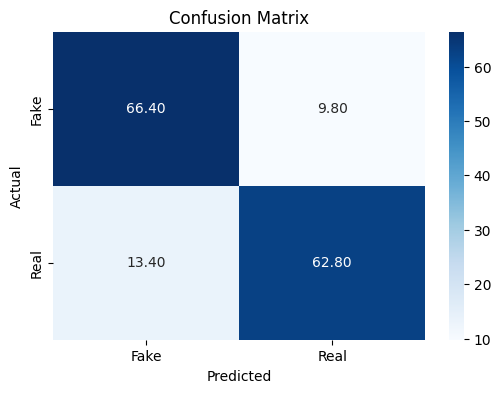

In [121]:
cm = confusion_matrix(y, y_pred_cv)
plt.figure(figsize=(6, 4))
sns.heatmap(cm / 5, fmt=".2f", annot=True, cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Random Forest

In [122]:
start_train = time.time()
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'rf__n_estimators': [200, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__bootstrap': [True, False]
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)


grid_search.fit(X_train, y_train)
end_train = time.time()

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best parameters: {'rf__bootstrap': True, 'rf__max_depth': None, 'rf__n_estimators': 200, 'selector__k': 13}
Best score: 0.9754098360655737


In [123]:
start_metrics = time.time()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
end_metrics = time.time()
metrics_time = end_metrics - start_metrics

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["Random Forest"] = accuracy

Accuracy: 0.954248366013072
Precision: 0.9726027397260274
Recall: 0.9342105263157895
F1-score: 0.9530201342281879


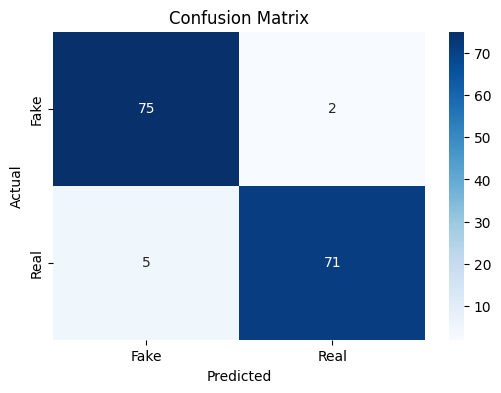

In [124]:
start_cm = time.time()
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
end_cm = time.time()
cm_time = end_cm - start_cm

In [125]:
start_cr = time.time()
print(classification_report(y_test, y_pred))
end_cr = time.time()
cr_time = end_cr - start_cr

              precision    recall  f1-score   support

           0       0.94      0.97      0.96        77
           1       0.97      0.93      0.95        76

    accuracy                           0.95       153
   macro avg       0.96      0.95      0.95       153
weighted avg       0.95      0.95      0.95       153



In [126]:
train_time = end_train - start_train
total_eval_time = pred_time + metrics_time + cm_time + cr_time

print(f"Training time: {train_time:.4f} seconds")
print(f"Evaluation time: {total_eval_time:.4f} seconds")

Training time: 221.2837 seconds
Evaluation time: 0.2820 seconds


In [127]:
y_pred_cv = cross_val_predict(best_model, X, y, cv=5)

accuracies = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
precisions = cross_val_score(best_model, X, y, cv=5, scoring='precision')
recalls = cross_val_score(best_model, X, y, cv=5, scoring='recall')
f1_scores = cross_val_score(best_model, X, y, cv=5, scoring='f1')

print(f"Average Accuracy from Cross-Validation: {np.mean(accuracies):.4f}")
print(f"Average Precision from Cross-Validation: {np.mean(precisions):.4f}")
print(f"Average Recall from Cross-Validation: {np.mean(recalls):.4f}")
print(f"Average F1-Score from Cross-Validation: {np.mean(f1_scores):.4f}")

Average Accuracy from Cross-Validation: 0.9685
Average Precision from Cross-Validation: 0.9743
Average Recall from Cross-Validation: 0.9634
Average F1-Score from Cross-Validation: 0.9682


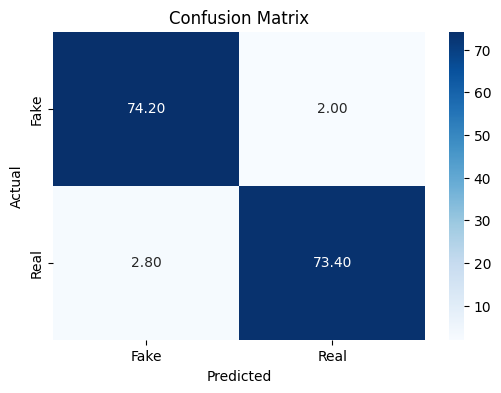

In [128]:
cm = confusion_matrix(y, y_pred_cv)
plt.figure(figsize=(6, 4))
sns.heatmap(cm / 5, fmt=".2f", annot=True, cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Decision Tree

In [129]:
start_train = time.time()
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'dt__max_depth': [None, 10, 20, 30],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)
end_train = time.time()
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

best_model = grid_search.best_estimator_
start_pred = time.time()
y_pred = best_model.predict(X_test)
end_pred = time.time()
pred_time = end_pred - start_pred

Best parameters: {'dt__criterion': 'gini', 'dt__max_depth': None, 'dt__min_samples_leaf': 4, 'dt__min_samples_split': 10, 'selector__k': 11}
Best score: 0.9376642731337217


In [130]:
start_metrics = time.time()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
end_metrics = time.time()
metrics_time = end_metrics - start_metrics

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["Decision Tree"] = accuracy

Accuracy: 0.8888888888888888
Precision: 0.9538461538461539
Recall: 0.8157894736842105
F1-score: 0.8794326241134752


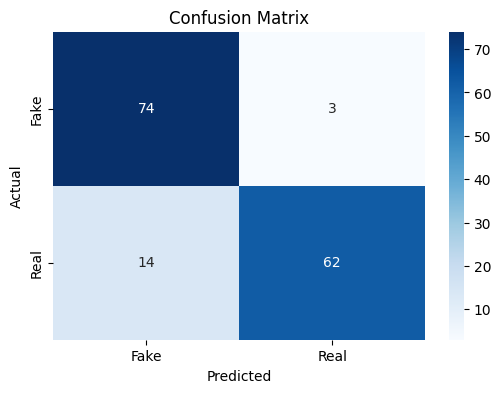

In [131]:
start_cm = time.time()
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
end_cm = time.time()
cm_time = end_cm - start_cm

In [132]:
start_cr = time.time()
print(classification_report(y_test, y_pred))
end_cr = time.time()
cr_time = end_cr - start_cr

              precision    recall  f1-score   support

           0       0.84      0.96      0.90        77
           1       0.95      0.82      0.88        76

    accuracy                           0.89       153
   macro avg       0.90      0.89      0.89       153
weighted avg       0.90      0.89      0.89       153



In [133]:
train_time = end_train - start_train
total_eval_time = pred_time + metrics_time + cm_time + cr_time

print(f"Training time: {train_time:.4f} seconds")
print(f"Evaluation time: {total_eval_time:.4f} seconds")

Training time: 20.7950 seconds
Evaluation time: 0.2338 seconds


In [134]:
y_pred_cv = cross_val_predict(best_model, X, y, cv=5)

accuracies = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
precisions = cross_val_score(best_model, X, y, cv=5, scoring='precision')
recalls = cross_val_score(best_model, X, y, cv=5, scoring='recall')
f1_scores = cross_val_score(best_model, X, y, cv=5, scoring='f1')

print(f"Average Accuracy from Cross-Validation: {np.mean(accuracies):.4f}")
print(f"Average Precision from Cross-Validation: {np.mean(precisions):.4f}")
print(f"Average Recall from Cross-Validation: {np.mean(recalls):.4f}")
print(f"Average F1-Score from Cross-Validation: {np.mean(f1_scores):.4f}")

Average Accuracy from Cross-Validation: 0.9108
Average Precision from Cross-Validation: 0.9114
Average Recall from Cross-Validation: 0.9109
Average F1-Score from Cross-Validation: 0.9109


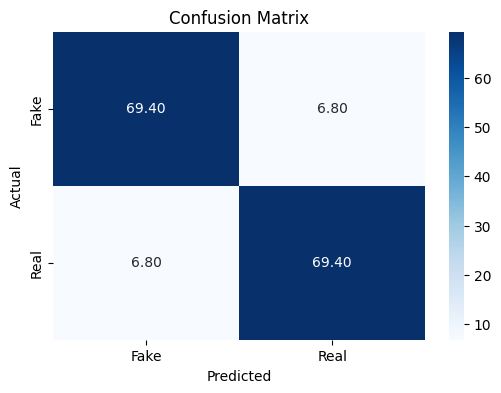

In [135]:
cm = confusion_matrix(y, y_pred_cv)
plt.figure(figsize=(6, 4))
sns.heatmap(cm / 5, fmt=".2f", annot=True, cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# CatBoost

In [136]:
start_train = time.time()
catboost= CatBoostClassifier(verbose=0, random_state=42)

catboost.fit(X_train, y_train)
end_train = time.time()
start_pred = time.time()
y_pred = catboost.predict(X_test)
end_pred = time.time()
pred_time = end_pred - start_pred

In [137]:
start_metrics = time.time()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
end_metrics = time.time()
metrics_time = end_metrics - start_metrics

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["CatBoost"] = accuracy

Accuracy: 0.9738562091503268
Precision: 0.9864864864864865
Recall: 0.9605263157894737
F1-score: 0.9733333333333334


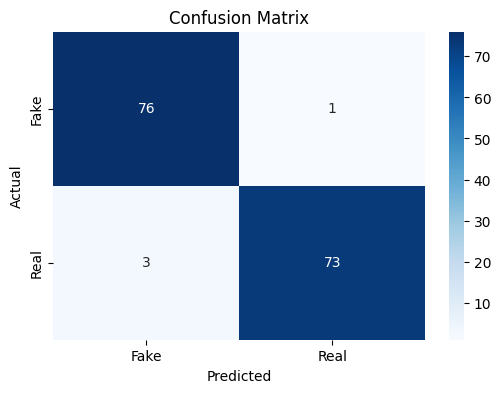

In [138]:
start_cm = time.time()
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
end_cm = time.time()
cm_time = end_cm - start_cm

In [139]:
start_cr = time.time()
print(classification_report(y_test, y_pred))
end_cr = time.time()
cr_time = end_cr - start_cr

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        77
           1       0.99      0.96      0.97        76

    accuracy                           0.97       153
   macro avg       0.97      0.97      0.97       153
weighted avg       0.97      0.97      0.97       153



In [140]:
train_time = end_train - start_train
total_eval_time = pred_time + metrics_time + cm_time + cr_time

print(f"Training time: {train_time:.4f} seconds")
print(f"Evaluation time: {total_eval_time:.4f} seconds")

Training time: 4.1665 seconds
Evaluation time: 0.2088 seconds


In [141]:
y_pred_cv = cross_val_predict(catboost, X, y, cv=5)

accuracies = cross_val_score(catboost, X, y, cv=5, scoring='accuracy')
precisions = cross_val_score(catboost, X, y, cv=5, scoring='precision')
recalls = cross_val_score(catboost, X, y, cv=5, scoring='recall')
f1_scores = cross_val_score(catboost, X, y, cv=5, scoring='f1')

print(f"Average Accuracy from Cross-Validation: {np.mean(accuracies):.4f}")
print(f"Average Precision from Cross-Validation: {np.mean(precisions):.4f}")
print(f"Average Recall from Cross-Validation: {np.mean(recalls):.4f}")
print(f"Average F1-Score from Cross-Validation: {np.mean(f1_scores):.4f}")

Average Accuracy from Cross-Validation: 0.9816
Average Precision from Cross-Validation: 0.9869
Average Recall from Cross-Validation: 0.9765
Average F1-Score from Cross-Validation: 0.9815


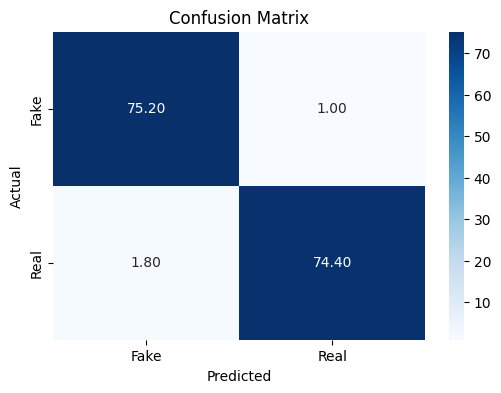

In [142]:
cm = confusion_matrix(y, y_pred_cv)
plt.figure(figsize=(6, 4))
sns.heatmap(cm / 5, fmt=".2f", annot=True, cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# eXtreme Gradient Boosting (XGB)

In [151]:
start_train = time.time()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgb.fit(X_train, y_train)
end_train = time.time()

start_pred = time.time()
y_pred = xgb.predict(X_test)
end_pred = time.time()
pred_time = end_pred - start_pred

start_metrics = time.time()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
end_metrics = time.time()
metrics_time = end_metrics - start_metrics

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["XGB"] = accuracy

Accuracy: 0.9738562091503268
Precision: 0.9864864864864865
Recall: 0.9605263157894737
F1-score: 0.9733333333333334


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


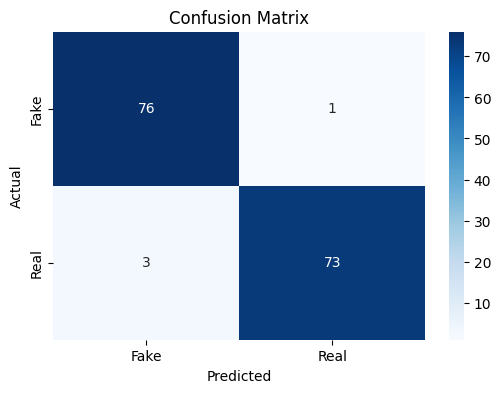

In [152]:
start_cm = time.time()
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
end_cm = time.time()
cm_time = end_cm - start_cm

In [153]:
start_cr = time.time()
print(classification_report(y_test, y_pred))
end_cr  = time.time()
cr_time = end_cr - start_cr

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        77
           1       0.99      0.96      0.97        76

    accuracy                           0.97       153
   macro avg       0.97      0.97      0.97       153
weighted avg       0.97      0.97      0.97       153



In [154]:
train_time = end_train - start_train
total_eval_time = pred_time + metrics_time + cm_time + cr_time

print(f"Training time: {train_time:.4f} seconds")
print(f"Evaluation time: {total_eval_time:.4f} seconds")

Training time: 0.1509 seconds
Evaluation time: 0.2258 seconds


In [168]:
from sklearn.model_selection import StratifiedKFold
import warnings
cv = StratifiedKFold(n_splits=5)
warnings.filterwarnings('ignore')

accuracies, precisions, recalls, f1_scores = [], [], [], []
y_true_all = []
y_pred_all = []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Average Precision: {np.mean(precisions):.4f}")
print(f"Average Recall: {np.mean(recalls):.4f}")
print(f"Average F1-score: {np.mean(f1_scores):.4f}")

Average Accuracy: 0.9725
Average Precision: 0.9838
Average Recall: 0.9608
Average F1-score: 0.9720


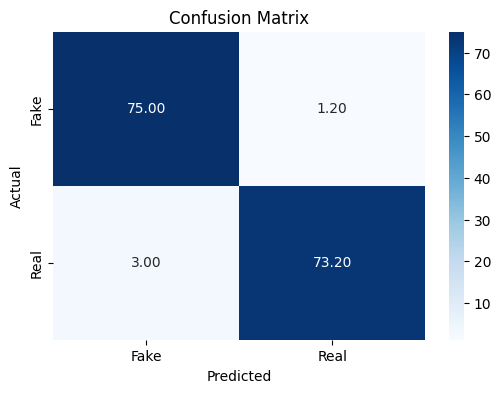

In [169]:
cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(6, 4))
sns.heatmap(cm / 5, fmt=".2f", annot=True, cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Long Short-Term Memory (LSTM)

In [170]:
def extract_mfcc_sequence(file_path, n_mfcc=13, max_length=100):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs = mfccs.T
    mfccs = pad_sequences([mfccs], maxlen=max_length, padding='post', truncating='post')[0]
    return mfccs

features = []
labels = []

for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_mfcc_sequence(file_path))
        labels.append(0)

for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_mfcc_sequence(file_path))
        labels.append(1)


X = np.array(features)
y = np.array(labels)

X_reshaped = X.reshape(X.shape[0], -1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])

y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [171]:
start_train = time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))
model.add(LSTM(32,kernel_regularizer=l2(0.0001)))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])
end_train = time.time()
train_time = end_train - start_train

start_eval = time.time()
loss, accuracy = model.evaluate(X_test, y_test)
end_eval = time.time()
eval_time = end_eval - start_eval

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
model_accuracy["LSTM"] = accuracy

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 435ms/step - accuracy: 0.6426 - loss: 0.6638 - val_accuracy: 0.7451 - val_loss: 0.5305
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 597ms/step - accuracy: 0.8242 - loss: 0.4295 - val_accuracy: 0.8431 - val_loss: 0.3310
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 286ms/step - accuracy: 0.8786 - loss: 0.3049 - val_accuracy: 0.9150 - val_loss: 0.3095
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.8874 - loss: 0.2842 - val_accuracy: 0.9020 - val_loss: 0.3035
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.9183 - loss: 0.2175 - val_accuracy: 0.9150 - val_loss: 0.2770
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.9451 - loss: 0.1680 - val_accuracy: 0.9346 - val_loss: 0.2168
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.9468 - loss: 0.1658 - val_accuracy: 0.8954 - val_loss: 0.4711
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - accuracy: 0.9410 - loss: 0.2246 - val_accuracy

In [172]:
print(f"Training time: {train_time:.4f} seconds")
print(f"Evaluation time: {eval_time:.4f} seconds")

Training time: 103.2923 seconds
Evaluation time: 2.0907 seconds


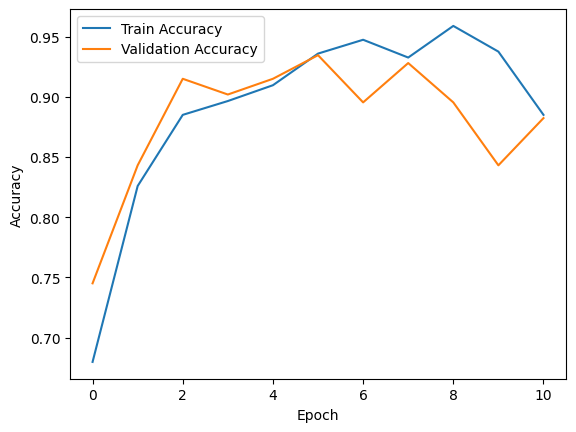

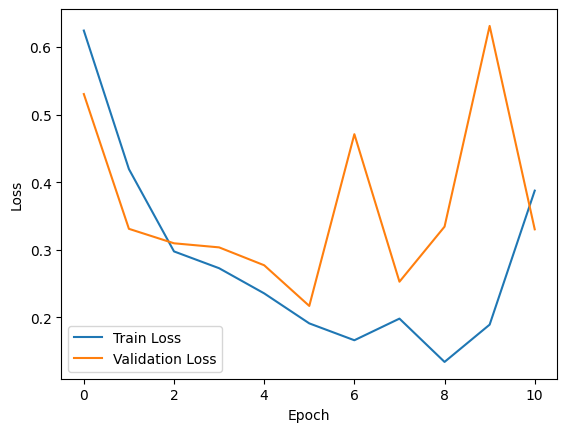

In [173]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Convolutional Neural Network (CNN)

In [174]:
def save_spectrogram(file_path, output_dir, n_mels=128, fmax=8000):
    y, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    plt.figure(figsize=(3, 3))
    librosa.display.specshow(spectrogram_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel', fmax=fmax)
    plt.axis('off')
    output_path = os.path.join(output_dir, os.path.basename(file_path).replace('.wav', '.png'))
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

fake_output_dir = "/kaggle/working/SPECTROGRAMS/FAKE"
real_output_dir = "/kaggle/working/SPECTROGRAMS/REAL"
os.makedirs(fake_output_dir, exist_ok=True)
os.makedirs(real_output_dir, exist_ok=True)

for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    if file_path.endswith('.wav'):
        save_spectrogram(file_path, fake_output_dir)

for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    if file_path.endswith('.wav'):
        save_spectrogram(file_path, real_output_dir)


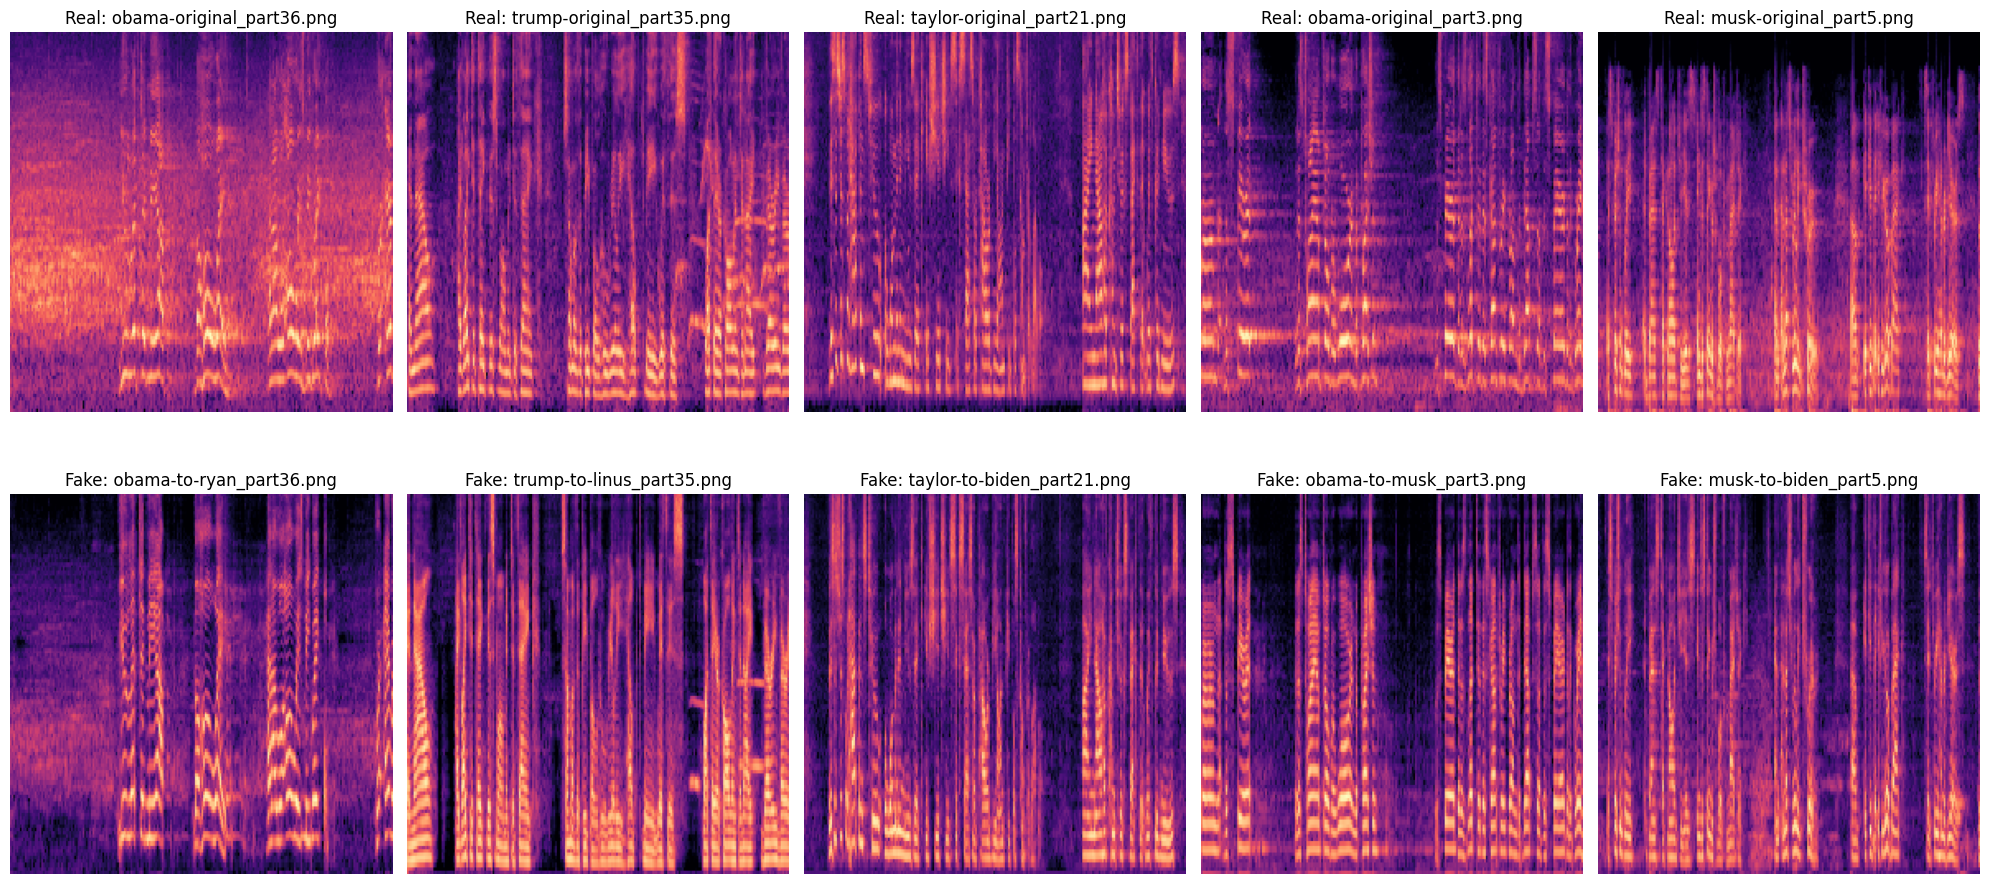

In [175]:
def display_real_fake_pairs(real_dir, fake_dir, num_pairs=5):
    real_files = [f for f in os.listdir(real_dir) if f.endswith('.png')]
    fake_files = [f for f in os.listdir(fake_dir) if f.endswith('.png')]

    pairs = []
    for real_file in real_files:
        real_base_name = real_file.split('-original_part')[0]
        part_number = real_file.split('_part')[-1].split('.png')[0]

        matching_fake = next(
            (f for f in fake_files if f.startswith(f"{real_base_name}-to-") and f.endswith(f"_part{part_number}.png")),
            None
        )

        if matching_fake:
            pairs.append((real_file, matching_fake))
        if len(pairs) >= num_pairs:
            break

    if not pairs:
        print("There are no spectrogram pairs available to display.")
        return

    plt.figure(figsize=(20, 2*len(pairs)))

    for i, (real_file, fake_file) in enumerate(pairs):
        real_path = os.path.join(real_dir, real_file)
        fake_path = os.path.join(fake_dir, fake_file)

        real_img = Image.open(real_path)
        fake_img = Image.open(fake_path)

        plt.subplot(2, len(pairs), i + 1)
        plt.imshow(real_img)
        plt.title(f"Real: {real_file}")
        plt.axis('off')

        plt.subplot(2,len(pairs), i + 6)
        plt.imshow(fake_img)
        plt.title(f"Fake: {fake_file}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_real_fake_pairs(real_output_dir, fake_output_dir)

In [176]:
train_dir = "/kaggle/working/SPECTROGRAMS"
batch_size = 32
img_height, img_width = 128, 128

train_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 610 images belonging to 2 classes.
Found 152 images belonging to 2 classes.


In [177]:
start_train = time.time()
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)
end_train = time.time()
train_time = end_train - start_train

start_eval = time.time()
loss, accuracy = model.evaluate(validation_generator)
end_eval = time.time()
eval_time = end_eval - start_eval
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
model_accuracy["CNN"] = accuracy

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4880 - loss: 1.2799 - val_accuracy: 0.5000 - val_loss: 0.6892
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5139 - loss: 0.6917 - val_accuracy: 0.5000 - val_loss: 0.6711
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6012 - loss: 0.6551 - val_accuracy: 0.8618 - val_loss: 0.5310
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7007 - loss: 0.5560 - val_accuracy: 0.7303 - val_loss: 0.5183
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7650 - loss: 0.4999 - val_accuracy: 0.8487 - val_loss: 0.3558
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8318 - loss: 0.3846 - val_accuracy: 0.8092 - val_loss: 0.4224
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8629 - loss: 0.3414 - val_accuracy: 0.7566 - val_loss: 0.4629
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8670 - loss: 0.3124 - val_accuracy: 0.8882 - val_loss:

In [178]:
print(f"Training time: {train_time:.4f} seconds")
print(f"Evaluation time: {eval_time:.4f} seconds")

Training time: 431.9923 seconds
Evaluation time: 2.7305 seconds


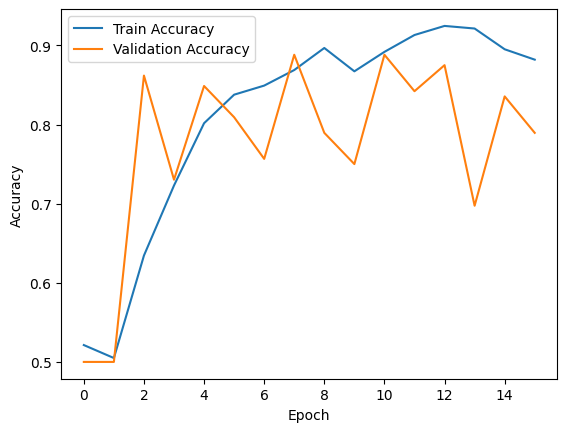

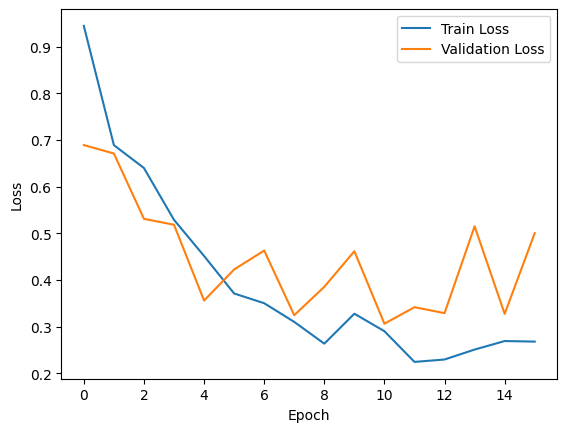

In [179]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

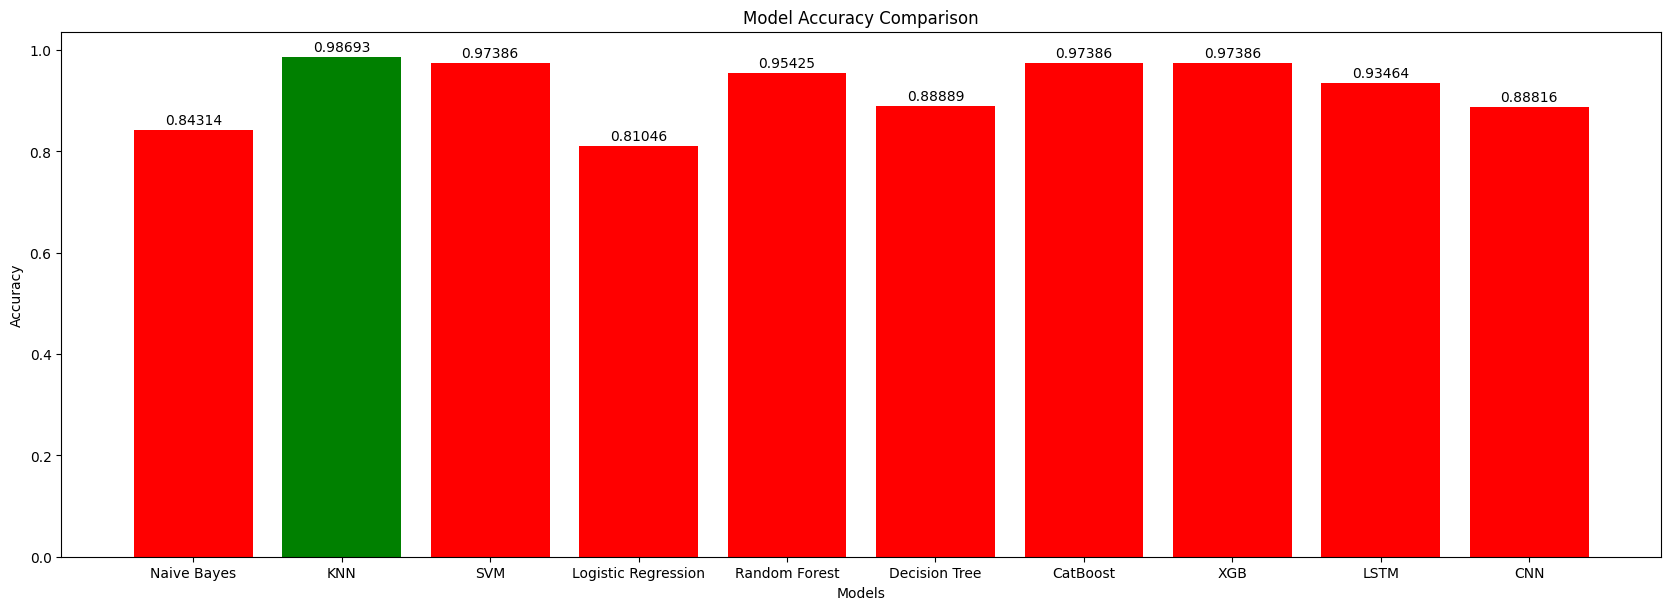

In [180]:
models = list(model_accuracy.keys())
accuracies = list(model_accuracy.values())

colors = ['green' if i == max(accuracies) else 'red' for i in accuracies]

plt.figure(figsize=(20, 7))
plt.bar(models, accuracies, color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.5f}", ha='center', va='bottom')
plt.show()